# 머신 러닝 교과서 - 파이토치편

<table align="left"><tr><td>
<a href="https://colab.research.google.com/github/rickiepark/ml-with-pytorch/blob/main/ch11/ch11.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="코랩에서 실행하기"/></a>
</td></tr></table>

## 패키지 버전 체크

check_packages.py 스크립트에서 로드하기 위해 폴더를 추가합니다:

In [10]:
import sys

# 코랩의 경우 깃허브 저장소로부터 python_environment_check.py를 다운로드 합니다.
if 'google.colab' in sys.modules:
    !wget https://raw.githubusercontent.com/rickiepark/ml-with-pytorch/main/python_environment_check.py
else:
    sys.path.insert(0, '..')

권장 패키지 버전을 확인하세요:

In [11]:
import sys
sys.path.append('..')  # 상위 디렉토리 추가

from python_environment_check import check_packages

In [12]:
from python_environment_check import check_packages


d = {
    'numpy': '1.21.2',
    'matplotlib': '3.4.3',
    'sklearn': '1.0',
}
check_packages(d)

[OK] numpy 2.2.6
[OK] matplotlib 3.10.3
[OK] sklearn 1.6.1


# 11장 - 다층 인공 신경망을 밑바닥부터 구현

### 목차

- 인공 신경망으로 복잡한 함수 모델링
    - 단일층 신경망 요약
    - 다층 신경망 구조
    - 정방향 계산으로 신경망 활성화 출력 계산
- 손글씨 숫자 분류
    - MNIST 데이터셋 구하기
    - 다층 퍼셉트론 구현
    - 신경망 훈련 루프 코딩
    - 신경망 모델의 성능 평가
- 인공 신경망 훈련
    - 손실 함수 계산
    - 역전파 알고리즘 이해
    - 역전파 알고리즘으로 신경망 훈련
- 신경망의 수렴
- 신경망 구현에 관한 몇 가지 첨언
- 요약

<br>
<br>

In [13]:
from IPython.display import Image
%matplotlib inline

# 인공 신경망으로 복잡한 함수 모델링

...

## 단일층 신경망 요약

In [14]:
Image(url='https://raw.githubusercontent.com/rickiepark/ml-with-pytorch/main/ch11/figures/11_01.png', width=600)

<br>
<br>

## 다층 신경망 구조

In [15]:
Image(url='https://raw.githubusercontent.com/rickiepark/ml-with-pytorch/main/ch11/figures/11_02.png', width=600)

In [16]:
Image(url='https://raw.githubusercontent.com/rickiepark/ml-with-pytorch/main/ch11/figures/11_03.png', width=500)

<br>
<br>

## 정방향 계산으로 신경망 활성화 출력 계산

<br>
<br>

# 손글씨 숫자 분류

...

## MNIST 데이터셋 구하기

MNIST 데이터셋은 http://yann.lecun.com/exdb/mnist/에 공개되어 있으며 다음 네 부분으로 구성되어 있습니다.

- 훈련 세트 이미지: train-images-idx3-ubyte.gz(9.9MB, 압축 해제 후 47MB, 60,000개 샘플)
- 훈련 세트 레이블: train-labels-idx1-ubyte.gz(29KB, 압축 해제 후 60KB, 60,000개 레이블)
- 테스트 세트 이미지: t10k-images-idx3-ubyte.gz(1.6MB, 압축 해제 후 7.8MB, 10,000개 샘플)
- 테스트 세트 레이블: t10k-labels-idx1-ubyte.gz(5KB, 압축 해제 후 10KB, 10,000개 레이블)

In [17]:
import ssl
ssl._create_default_https_context = ssl._create_unverified_context

In [18]:
from sklearn.datasets import fetch_openml


X, y = fetch_openml('mnist_784', version=1, return_X_y=True, parser='auto')
X = X.values
y = y.astype(int).values

print(X.shape)
print(y.shape)

(70000, 784)
(70000,)


[-1, 1] 범위로 정규화합니다:

In [19]:
X = ((X / 255.) - .5) * 2

각 클래스의 첫 번째 이미지를 그립니다:

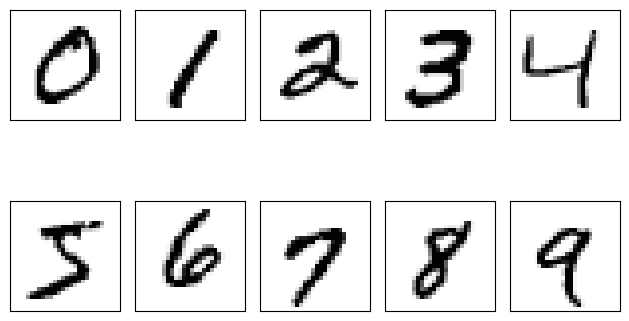

In [20]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(nrows=2, ncols=5, sharex=True, sharey=True)
ax = ax.flatten()
for i in range(10):
    img = X[y == i][0].reshape(28, 28)
    ax[i].imshow(img, cmap='Greys')

ax[0].set_xticks([])
ax[0].set_yticks([])
plt.tight_layout()
#plt.savefig('figures/11_4.png', dpi=300)
plt.show()

숫자 7 샘플 25개를 그립니다:

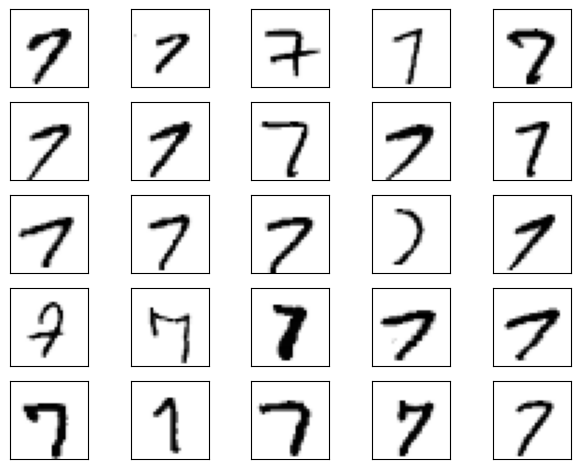

In [21]:
fig, ax = plt.subplots(nrows=5, ncols=5, sharex=True, sharey=True)
ax = ax.flatten()
for i in range(25):
    img = X[y == 7][i].reshape(28, 28)
    ax[i].imshow(img, cmap='Greys')

ax[0].set_xticks([])
ax[0].set_yticks([])
plt.tight_layout()
# plt.savefig('figures/11_5.png', dpi=300)
plt.show()

트레이닝, 검증, 테스트 세트로 나눕니다:

In [22]:
from sklearn.model_selection import train_test_split


X_temp, X_test, y_temp, y_test = train_test_split(
    X, y, test_size=10000, random_state=123, stratify=y)

X_train, X_valid, y_train, y_valid = train_test_split(
    X_temp, y_temp, test_size=5000, random_state=123, stratify=y_temp)


# 사용하지 않는 배열을 삭제하여 메모리를 확보합니다:
del X_temp, y_temp, X, y

<br>
<br>

## 다층 퍼셉트론 구현

In [23]:
import numpy as np

In [24]:
##########################
### 모델
##########################

def sigmoid(z):
    return 1. / (1. + np.exp(-z))


def int_to_onehot(y, num_labels):

    ary = np.zeros((y.shape[0], num_labels))
    for i, val in enumerate(y):
        ary[i, val] = 1

    return ary


class NeuralNetMLP:

    def __init__(self, num_features, num_hidden, num_classes, random_seed=123):
        super().__init__()

        self.num_classes = num_classes

        # 은닉층
        rng = np.random.RandomState(random_seed)

        self.weight_h = rng.normal(
            loc=0.0, scale=0.1, size=(num_hidden, num_features))
        self.bias_h = np.zeros(num_hidden)

        # 출력층
        self.weight_out = rng.normal(
            loc=0.0, scale=0.1, size=(num_classes, num_hidden))
        self.bias_out = np.zeros(num_classes)

    def forward(self, x):
        # 은닉층
        # 입력 차원: [n_examples, n_features] dot [n_hidden, n_features].T
        # 출력 차원: [n_examples, n_hidden]
        z_h = np.dot(x, self.weight_h.T) + self.bias_h
        a_h = sigmoid(z_h)

        # 출력층
        # 입력 차원: [n_examples, n_hidden] dot [n_classes, n_hidden].T
        # 출력 차원: [n_examples, n_classes]
        z_out = np.dot(a_h, self.weight_out.T) + self.bias_out
        a_out = sigmoid(z_out)
        return a_h, a_out

    def backward(self, x, a_h, a_out, y):

        #########################
        ### 출력층 가중치
        #########################

        # 원-핫 인코딩
        y_onehot = int_to_onehot(y, self.num_classes)

        # 파트 1: dLoss/dOutWeights
        ## = dLoss/dOutAct * dOutAct/dOutNet * dOutNet/dOutWeight
        ## 재사용을 위해 DeltaOut = dLoss/dOutAct * dOutAct/dOutNet

        # 입력/출력 차원: [n_examples, n_classes]
        d_loss__d_a_out = 2.*(a_out - y_onehot) / y.shape[0]

        # 입력/출력 차원: [n_examples, n_classes]
        d_a_out__d_z_out = a_out * (1. - a_out) # sigmoid derivative

        # 출력 차원: [n_examples, n_classes]
        delta_out = d_loss__d_a_out * d_a_out__d_z_out # "delta (rule) placeholder"

        # 출력 가중치를 위한 그레이디언트

        # [n_examples, n_hidden]
        d_z_out__dw_out = a_h

        # 입력 차원: [n_classes, n_examples] dot [n_examples, n_hidden]
        # 출력 차원: [n_classes, n_hidden]
        d_loss__dw_out = np.dot(delta_out.T, d_z_out__dw_out)
        d_loss__db_out = np.sum(delta_out, axis=0)


        #################################
        # 파트 2: dLoss/dHiddenWeights
        ## = DeltaOut * dOutNet/dHiddenAct * dHiddenAct/dHiddenNet * dHiddenNet/dWeight

        # [n_classes, n_hidden]
        d_z_out__a_h = self.weight_out

        # 출력 차원: [n_examples, n_hidden]
        d_loss__a_h = np.dot(delta_out, d_z_out__a_h)

        # [n_examples, n_hidden]
        d_a_h__d_z_h = a_h * (1. - a_h) # sigmoid derivative

        # [n_examples, n_features]
        d_z_h__d_w_h = x

        # 출력 차원: [n_hidden, n_features]
        d_loss__d_w_h = np.dot((d_loss__a_h * d_a_h__d_z_h).T, d_z_h__d_w_h)
        d_loss__d_b_h = np.sum((d_loss__a_h * d_a_h__d_z_h), axis=0)

        return (d_loss__dw_out, d_loss__db_out,
                d_loss__d_w_h, d_loss__d_b_h)

In [25]:
model = NeuralNetMLP(num_features=28*28,
                     num_hidden=50,
                     num_classes=10)

## 신경망 훈련 루프 코딩

데이터 로더 정의하기:

In [26]:
import numpy as np

num_epochs = 50
minibatch_size = 100


def minibatch_generator(X, y, minibatch_size):
    indices = np.arange(X.shape[0])
    np.random.shuffle(indices)

    for start_idx in range(0, indices.shape[0] - minibatch_size
                           + 1, minibatch_size):
        batch_idx = indices[start_idx:start_idx + minibatch_size]

        yield X[batch_idx], y[batch_idx]


# 훈련 에포크를 반복합니다.
for i in range(num_epochs):

    # 미니 배치를 반복합니다.
    minibatch_gen = minibatch_generator(
        X_train, y_train, minibatch_size)

    for X_train_mini, y_train_mini in minibatch_gen:

        break

    break

print(X_train_mini.shape)
print(y_train_mini.shape)

(100, 784)
(100,)


손실 및 정확도를 계산하는 함수 정의하기

In [27]:
def mse_loss(targets, probas, num_labels=10):
    onehot_targets = int_to_onehot(targets, num_labels=num_labels)
    return np.mean((onehot_targets - probas)**2)


def accuracy(targets, predicted_labels):
    return np.mean(predicted_labels == targets)


_, probas = model.forward(X_valid)
mse = mse_loss(y_valid, probas)

predicted_labels = np.argmax(probas, axis=1)
acc = accuracy(y_valid, predicted_labels)

print(f'검증 세트 MSE: {mse:.1f}')
print(f'검증 세트 정확도: {acc*100:.1f}%')

검증 세트 MSE: 0.3
검증 세트 정확도: 9.4%


In [28]:
def compute_mse_and_acc(nnet, X, y, num_labels=10, minibatch_size=100):
    mse, correct_pred, num_examples = 0., 0, 0
    minibatch_gen = minibatch_generator(X, y, minibatch_size)

    for i, (features, targets) in enumerate(minibatch_gen):

        _, probas = nnet.forward(features)
        predicted_labels = np.argmax(probas, axis=1)

        onehot_targets = int_to_onehot(targets, num_labels=num_labels)
        loss = np.mean((onehot_targets - probas)**2)
        correct_pred += (predicted_labels == targets).sum()

        num_examples += targets.shape[0]
        mse += loss

    mse = mse/i
    acc = correct_pred/num_examples
    return mse, acc

In [29]:
mse, acc = compute_mse_and_acc(model, X_valid, y_valid)
print(f'검증 세트 MSE: {mse:.1f}')
print(f'검증 세트 정확도: {acc*100:.1f}%')

검증 세트 MSE: 0.3
검증 세트 정확도: 9.4%


In [30]:
def train(model, X_train, y_train, X_valid, y_valid, num_epochs,
          learning_rate=0.1):

    epoch_loss = []
    epoch_train_acc = []
    epoch_valid_acc = []

    for e in range(num_epochs):

        # 미니 배치를 반복합니다.
        minibatch_gen = minibatch_generator(
            X_train, y_train, minibatch_size)

        for X_train_mini, y_train_mini in minibatch_gen:

            #### 출력 계산 ####
            a_h, a_out = model.forward(X_train_mini)

            #### 그레이디언트 계산 ####
            d_loss__d_w_out, d_loss__d_b_out, d_loss__d_w_h, d_loss__d_b_h = \
                model.backward(X_train_mini, a_h, a_out, y_train_mini)

            #### 가중치 업데이트 ####
            model.weight_h -= learning_rate * d_loss__d_w_h
            model.bias_h -= learning_rate * d_loss__d_b_h
            model.weight_out -= learning_rate * d_loss__d_w_out
            model.bias_out -= learning_rate * d_loss__d_b_out

        #### 에포크 로깅 ####
        train_mse, train_acc = compute_mse_and_acc(model, X_train, y_train)
        valid_mse, valid_acc = compute_mse_and_acc(model, X_valid, y_valid)
        train_acc, valid_acc = train_acc*100, valid_acc*100
        epoch_train_acc.append(train_acc)
        epoch_valid_acc.append(valid_acc)
        epoch_loss.append(train_mse)
        print(f'에포크: {e+1:03d}/{num_epochs:03d} '
              f'| 훈련 MSE: {train_mse:.2f} '
              f'| 훈련 정확도: {train_acc:.2f}% '
              f'| 검증 정확도: {valid_acc:.2f}%')

    return epoch_loss, epoch_train_acc, epoch_valid_acc

In [31]:
np.random.seed(123) # 훈련 세트 셔플링을 위해

epoch_loss, epoch_train_acc, epoch_valid_acc = train(
    model, X_train, y_train, X_valid, y_valid,
    num_epochs=50, learning_rate=0.1)

에포크: 001/050 | 훈련 MSE: 0.05 | 훈련 정확도: 76.15% | 검증 정확도: 75.98%
에포크: 002/050 | 훈련 MSE: 0.03 | 훈련 정확도: 85.45% | 검증 정확도: 85.04%
에포크: 003/050 | 훈련 MSE: 0.02 | 훈련 정확도: 87.82% | 검증 정확도: 87.60%
에포크: 004/050 | 훈련 MSE: 0.02 | 훈련 정확도: 89.36% | 검증 정확도: 89.28%
에포크: 005/050 | 훈련 MSE: 0.02 | 훈련 정확도: 90.21% | 검증 정확도: 90.04%
에포크: 006/050 | 훈련 MSE: 0.02 | 훈련 정확도: 90.67% | 검증 정확도: 90.54%
에포크: 007/050 | 훈련 MSE: 0.02 | 훈련 정확도: 91.12% | 검증 정확도: 90.82%
에포크: 008/050 | 훈련 MSE: 0.02 | 훈련 정확도: 91.43% | 검증 정확도: 91.26%
에포크: 009/050 | 훈련 MSE: 0.01 | 훈련 정확도: 91.84% | 검증 정확도: 91.50%
에포크: 010/050 | 훈련 MSE: 0.01 | 훈련 정확도: 92.04% | 검증 정확도: 91.84%
에포크: 011/050 | 훈련 MSE: 0.01 | 훈련 정확도: 92.30% | 검증 정확도: 92.08%
에포크: 012/050 | 훈련 MSE: 0.01 | 훈련 정확도: 92.51% | 검증 정확도: 92.24%
에포크: 013/050 | 훈련 MSE: 0.01 | 훈련 정확도: 92.65% | 검증 정확도: 92.30%
에포크: 014/050 | 훈련 MSE: 0.01 | 훈련 정확도: 92.80% | 검증 정확도: 92.60%
에포크: 015/050 | 훈련 MSE: 0.01 | 훈련 정확도: 93.04% | 검증 정확도: 92.78%
에포크: 016/050 | 훈련 MSE: 0.01 | 훈련 정확도: 93.14% | 검증 정확도: 92.68%
에포크: 017

## 신경망 모델의 성능 평가

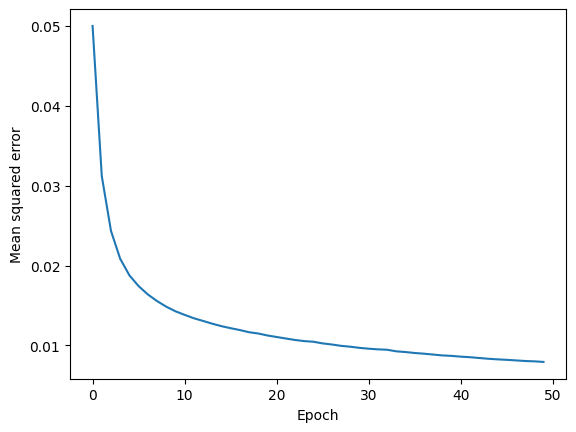

In [32]:
plt.plot(range(len(epoch_loss)), epoch_loss)
plt.ylabel('Mean squared error')
plt.xlabel('Epoch')
#plt.savefig('figures/11_07.png', dpi=300)
plt.show()

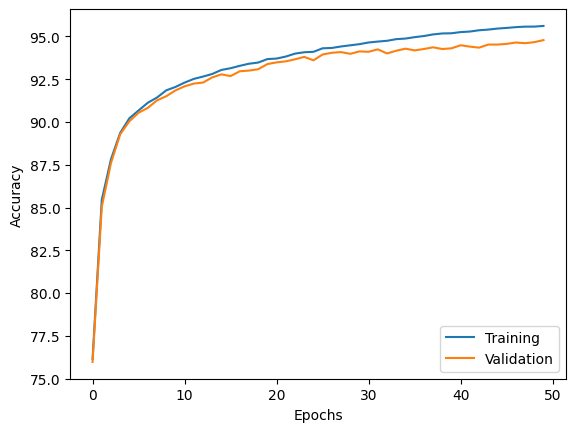

In [33]:
plt.plot(range(len(epoch_train_acc)), epoch_train_acc,
         label='Training')
plt.plot(range(len(epoch_valid_acc)), epoch_valid_acc,
         label='Validation')
plt.ylabel('Accuracy')
plt.xlabel('Epochs')
plt.legend(loc='lower right')
#plt.savefig('figures/11_08.png', dpi=300)
plt.show()

In [34]:
test_mse, test_acc = compute_mse_and_acc(model, X_test, y_test)
print(f'테스트 정확도: {test_acc*100:.2f}%')

테스트 정확도: 94.54%


예측 실패 샘플 출력하기:

In [35]:
X_test_subset = X_test[:1000, :]
y_test_subset = y_test[:1000]

_, probas = model.forward(X_test_subset)
test_pred = np.argmax(probas, axis=1)

misclassified_images = X_test_subset[y_test_subset != test_pred][:25]
misclassified_labels = test_pred[y_test_subset != test_pred][:25]
correct_labels = y_test_subset[y_test_subset != test_pred][:25]

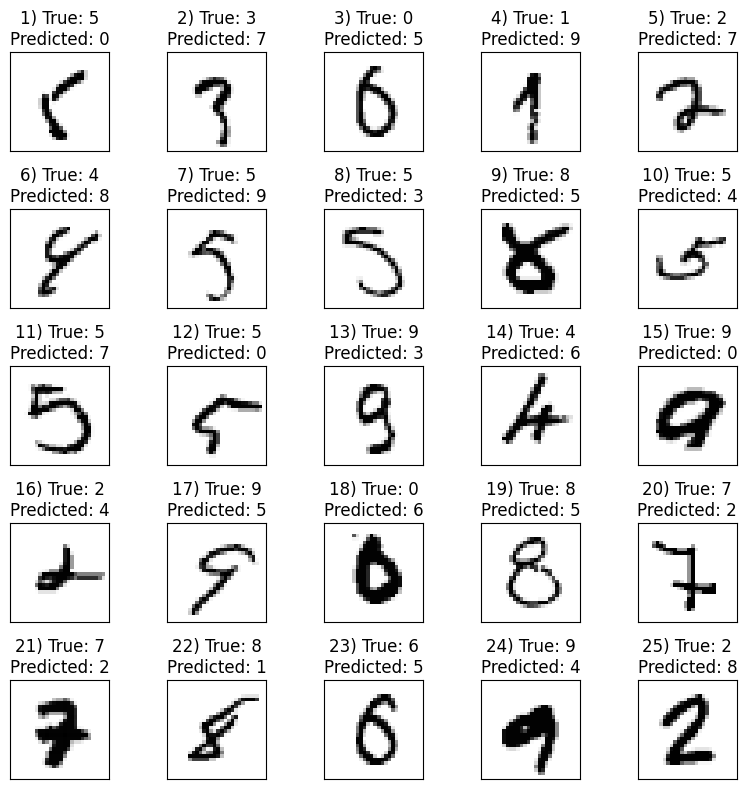

In [36]:
fig, ax = plt.subplots(nrows=5, ncols=5,
                       sharex=True, sharey=True, figsize=(8, 8))
ax = ax.flatten()
for i in range(25):
    img = misclassified_images[i].reshape(28, 28)
    ax[i].imshow(img, cmap='Greys', interpolation='nearest')
    ax[i].set_title(f'{i+1}) '
                    f'True: {correct_labels[i]}\n'
                    f'Predicted: {misclassified_labels[i]}')

ax[0].set_xticks([])
ax[0].set_yticks([])
plt.tight_layout()
#plt.savefig('figures/11_09.png', dpi=300)
plt.show()

<br>
<br>

# 인공 신경망 훈련

...

## 손실 함수 계산

In [37]:
Image(url='https://raw.githubusercontent.com/rickiepark/ml-with-pytorch/main/ch11/figures/11_10.png', width=300)

<br>
<br>

## 역전파 알고리즘 이해

...

## 역전파 알고리즘으로 신경망 훈련

In [38]:
Image(url='https://raw.githubusercontent.com/rickiepark/ml-with-pytorch/main/ch11/figures/11_11.png', width=400)

In [39]:
Image(url='https://raw.githubusercontent.com/rickiepark/ml-with-pytorch/main/ch11/figures/11_12.png', width=500)

In [40]:
Image(url='https://raw.githubusercontent.com/rickiepark/ml-with-pytorch/main/ch11/figures/11_13.png', width=500)

<br>
<br>

# 신경망의 수렴

In [41]:
Image(url='https://raw.githubusercontent.com/rickiepark/ml-with-pytorch/main/ch11/figures/11_14.png', width=500)

<br>
<br>

...

# 요약

...